# Credit Card Lead Prediction
## Job-A-Thon (28th-30th May 2021)

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)


### Libraries

In [1]:
import os
import sys

import pandas as pd
import numpy as np

# Data Viz
import dtale
import matplotlib.pyplot as plt
import seaborn as sns

# Data Imputation
import datawig
from impyute.imputation.cs import fast_knn
from impyute.imputation.cs import mice

# Models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, plot_roc_curve
from catboost import CatBoostClassifier


### Constants and Configurations

In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
DATA_DIR = os.path.join(BASE_DIR, "data")
MODEL_DIR = os.path.join(BASE_DIR, "model")

In [3]:
train = pd.read_csv(f"{DATA_DIR}/train_s3TEQDk.csv")
test = pd.read_csv(f"{DATA_DIR}/test_mSzZ8RL.csv")

dtale.show(train)

### Data Cleaning & Transformation

In [4]:

def clean_data(df):

    if 'ID' in df.columns:
        df.set_index(['ID'], inplace=True)


    for col in ['Credit_Product', 'Is_Active', 'Gender', 'Occupation']:

        if not all(isinstance(x, (int, float)) for x in df[col].unique().tolist()):
            df[col] = df[col].map({'Yes': 1, 'No': 0, # np.nan: 0,
                                   'Female': 0, 'Male': 1,
                                   'Other': 0, 'Self_Employed': 1, 'Salaried': 2, 'Entrepreneur': 3
                                  })
            # df[col] = df[col].astype(int)
            print(f"{col}: {df[col].value_counts()}\n")

    return df

print("Cleaning Training DataSet")
transformed_train = clean_data(train)
print("Cleaning Testing DataSet")
transformed_test = clean_data(test)
transformed_train

Cleaning Training DataSet
Credit_Product: 0.0    144357
1.0     72043
Name: Credit_Product, dtype: int64

Is_Active: 0    150290
1     95435
Name: Is_Active, dtype: int64

Gender: 1    134197
0    111528
Name: Gender, dtype: int64

Occupation: 1    100886
2     71999
0     70173
3      2667
Name: Occupation, dtype: int64

Cleaning Testing DataSet
Credit_Product: 0.0    61608
1.0    31182
Name: Credit_Product, dtype: int64

Is_Active: 0    63797
1    41515
Name: Is_Active, dtype: int64

Gender: 1    57705
0    47607
Name: Gender, dtype: int64

Occupation: 1    43192
2    30913
0    30131
3     1076
Name: Occupation, dtype: int64



,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
ID,,,,,,,,,,
NNVBBKZB,0,73,RG268,0,X3,43,0.0,1045696,0,0
IDD62UNG,0,30,RG277,2,X1,32,0.0,581988,0,0
HD3DSEMC,0,56,RG268,1,X3,26,0.0,1484315,1,0
BF3NC7KV,1,34,RG270,2,X1,19,0.0,470454,0,0
TEASRWXV,0,30,RG282,2,X1,33,0.0,886787,0,0
...,...,...,...,...,...,...,...,...,...,...
BPAWWXZN,1,51,RG284,1,X3,109,NaN,1925586,0,0
HFNB7JY8,1,27,RG268,2,X1,15,0.0,862952,1,0
GEHAUCWT,0,26,RG281,2,X1,13,0.0,670659,0,0


In [5]:
# One Hot Encoding - Using Pandas get_dummies()

categorical_features = [x for x in transformed_train.select_dtypes(include='object').columns.tolist() if x not in ['ID']]


# Transform categorical features in training dataset

transformed_train = pd.get_dummies(transformed_train, prefix_sep="__",
                                   columns=categorical_features)
cat_dummies = [col for col in transformed_train
               if "__" in col
               and col.split("__")[0] in categorical_features]
processed_columns = list(transformed_train.columns[:])


# Clean up unseen test data points

transformed_test = pd.get_dummies(transformed_test, prefix_sep="__", 
                                  columns=categorical_features)


# Remove additional columns

for col in transformed_test.columns:
    if ("__" in col) and (col.split("__")[0] in categorical_features) and col not in cat_dummies:
        print("Removing additional feature {}".format(col))
        transformed_test.drop(col, axis=1, inplace=True)


# Add columns in testing dataset, if not exists
for col in cat_dummies:
    if col not in transformed_test.columns:
        print("Adding missing feature {}".format(col))
        transformed_test[col] = 0


transformed_train

,Gender,Age,Occupation,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Region_Code__RG250,Region_Code__RG251,...,Region_Code__RG279,Region_Code__RG280,Region_Code__RG281,Region_Code__RG282,Region_Code__RG283,Region_Code__RG284,Channel_Code__X1,Channel_Code__X2,Channel_Code__X3,Channel_Code__X4
ID,,,,,,,,,,,,,,,,,,,,,
NNVBBKZB,0,73,0,43,0.0,1045696,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
IDD62UNG,0,30,2,32,0.0,581988,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
HD3DSEMC,0,56,1,26,0.0,1484315,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
BF3NC7KV,1,34,2,19,0.0,470454,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
TEASRWXV,0,30,2,33,0.0,886787,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BPAWWXZN,1,51,1,109,NaN,1925586,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
HFNB7JY8,1,27,2,15,0.0,862952,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
GEHAUCWT,0,26,2,13,0.0,670659,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [23]:
# # Imputation of Credit_Product


# #################### DATAWIG ####################

# # # Initialize a SimpleImputer model
# # imputer = datawig.SimpleImputer(
# #     input_columns=['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
# #                     'Vintage', 'Avg_Account_Balance', 'Is_Active', 'Is_Lead'],
# #     output_column= 'Credit_Product',
# #     output_path = f'{MODEL_DIR}/credit_product_imputer_model' # stores model data and metrics
# #     )

# # # Fit an imputer model on the train data
# # imputer.fit(train_df=train.loc[pd.notnull(train['Credit_Product'])], num_epochs=10)

# # # Impute missing values and return original dataframe with predictions
# # imputed = imputer.predict(train)

# # # # Load saved model
# # # imputer = datawig.SimpleImputer.load(f'{MODEL_DIR}/imputer_model')
# # # imputed = imputer.predict(train)


# # # # Load metrics from the validation set
# # # metrics = imputer.load_metrics()
# # # metrics


# #################### IMPYUTE - KNN ####################

# # sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# # start the KNN training
# imputed_training = fast_knn(transformed_train.values, k=30)
# imputed_testing = fast_knn(transformed_test.values, k=30)


# #################### IMPYUTE - mice ####################


# # # start the MICE training
# # imputed_training=mice(transformed_train.values)
# # imputed_testing=mice(transformed_test.values)

# # ---------------------
 
# # Training dataframe after imputation and transformation
# imputed_transformed_train = pd.DataFrame(imputed_training, index=transformed_train.index, columns=transformed_train.columns)
# imputed_transformed_train['Credit_Product'] = np.round(imputed_transformed_train['Credit_Product'], 0)


# # Testing dataframe after imputation and transformation
# imputed_transformed_test = pd.DataFrame(imputed_testing, index=transformed_test.index, columns=transformed_test.columns)
# imputed_transformed_test['Credit_Product'] = np.round(imputed_transformed_test['Credit_Product'], 0)

# #################### dropna() Missing values ####################

# # imputed_transformed_train = transformed_train.dropna(subset=['Credit_Product'])
# # imputed_transformed_test = transformed_test.dropna(subset=['Credit_Product'])

# print(f"Training Unique Credit Product Values:\n{imputed_transformed_train['Credit_Product'].value_counts()}")
# print(f"Testing Unique Credit Product Values:\n{imputed_transformed_test['Credit_Product'].value_counts()}")

Training Unique Credit Product Values:
0.0    172110
1.0     73615
Name: Credit_Product, dtype: int64
Testing Unique Credit Product Values:
0.0    73367
1.0    31945
Name: Credit_Product, dtype: int64


#### Sampling Techniques

#### CatBoost Model Training

In [202]:
# Defining Features & Target for Catboost

target = ['Is_Lead']
features = train.columns.difference(target)
# features = ['Credit_Product', 'Occupation', 'Vintage']

X = train[features]
y = train[target]


# Train Valid Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}")

# Model Training

############################ CATBOOST ############################

categorical_features = [x for x in X.select_dtypes(include='object').columns.tolist() if x not in ['ID']]

params = {
#     'iterations': 10000,
    'learning_rate': 0.01,
    'depth': 12,
    'cat_features': categorical_features,
    'eval_metric': 'AUC',
    'random_seed': 42,
    # 'n_estimators': 10000,
}

# Initialize CatBoostClassifier
model = CatBoostClassifier(**params, early_stopping_rounds=300)
# Fit model
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=categorical_features, verbose=True) # , plot=True


X_train: (196580, 9)
X_test: (49145, 9)
y_train: (196580, 1)
y_test: (49145, 1)
0:	test: 0.8655198	best: 0.8655198 (0)	total: 194ms	remaining: 3m 14s
1:	test: 0.8685980	best: 0.8685980 (1)	total: 373ms	remaining: 3m 5s
2:	test: 0.8678515	best: 0.8685980 (1)	total: 443ms	remaining: 2m 27s
3:	test: 0.8679740	best: 0.8685980 (1)	total: 701ms	remaining: 2m 54s
4:	test: 0.8677500	best: 0.8685980 (1)	total: 743ms	remaining: 2m 27s
5:	test: 0.8682115	best: 0.8685980 (1)	total: 824ms	remaining: 2m 16s
6:	test: 0.8681627	best: 0.8685980 (1)	total: 890ms	remaining: 2m 6s
7:	test: 0.8682004	best: 0.8685980 (1)	total: 959ms	remaining: 1m 58s
8:	test: 0.8680420	best: 0.8685980 (1)	total: 1.02s	remaining: 1m 52s
9:	test: 0.8681066	best: 0.8685980 (1)	total: 1.27s	remaining: 2m 6s
10:	test: 0.8680666	best: 0.8685980 (1)	total: 1.35s	remaining: 2m 1s
11:	test: 0.8682936	best: 0.8685980 (1)	total: 1.56s	remaining: 2m 8s
12:	test: 0.8683533	best: 0.8685980 (1)	total: 1.81s	remaining: 2m 17s
13:	test: 0.

In [203]:
# Get predicted classes
preds_class = model.predict(X_test)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_test)


preds_df = y_test
preds_df = pd.concat([preds_df.reset_index(drop=True), pd.DataFrame(preds_proba)], ignore_index=True, axis=1).set_index(y_test.index)
preds_df.loc[(preds_df[0] == 1)].median(axis=0)



0    1.000000
1    0.440754
2    0.559246
dtype: float64

roc_auc_score: 0.7492162344957242
roc_auc_score: (array([0.        , 0.04152452, 1.        ]), array([0.        , 0.53995699, 1.        ]), array([2, 1, 0]))
precision: [0.23654492 0.80114869 1.        ]
recall: [1.         0.53995699 0.        ]
thresholds: [0 1]
confusion_matrix: [[35962  1558]
 [ 5348  6277]]


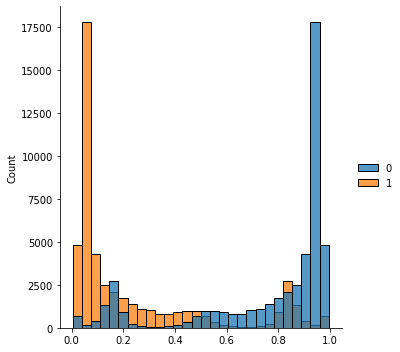

In [204]:
print(f'roc_auc_score: {roc_auc_score(y_test, preds_class)}')
print(f'roc_auc_score: {roc_curve(y_test, preds_class)}')
precision, recall, thresholds = precision_recall_curve(y_test, preds_class)
print(f'precision: {precision}\nrecall: {recall}\nthresholds: {thresholds}')
print(f'confusion_matrix: {confusion_matrix(y_test, preds_class)}')


sns.displot(preds_proba)


In [205]:
threshold = 0.2415

# preds_proba_df = pd.DataFrame(preds_proba)
# df.loc[(df[0] >= threshold), 'y_pred'] = 0

preds_class = np.where(preds_proba[:, 1] >= threshold, 1, 0)

print(f'roc_auc_score: {roc_auc_score(y_test, preds_class)}')
print(f'roc_auc_score: {roc_curve(y_test, preds_class)}')
precision, recall, thresholds = precision_recall_curve(y_test, preds_class)
print(f'precision: {precision}\nrecall: {recall}\nthresholds: {thresholds}')
print(f'confusion_matrix: {confusion_matrix(y_test, preds_class)}')


roc_auc_score: 0.8039033175138135
roc_auc_score: (array([0.        , 0.16002132, 1.        ]), array([0.        , 0.76782796, 1.        ]), array([2, 1, 0]))
precision: [0.23654492 0.59785666 1.        ]
recall: [1.         0.76782796 0.        ]
thresholds: [0 1]
confusion_matrix: [[31516  6004]
 [ 2699  8926]]


In [206]:

# # calculate roc curves
# fpr, tpr, thresholds = roc_curve(y_test, preds_class)
# # calculate the g-mean for each threshold
# gmeans = np.sqrt(tpr * (1-fpr))
# # locate the index of the largest g-mean
# ix = np.argmax(gmeans)
# print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# # plot the roc curve for the model
# plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
# plt.plot(fpr, tpr, marker='.', label='CatBoost')
# plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend()
# # show the plot
# plt.show()

<AxesSubplot:xlabel='importance'>

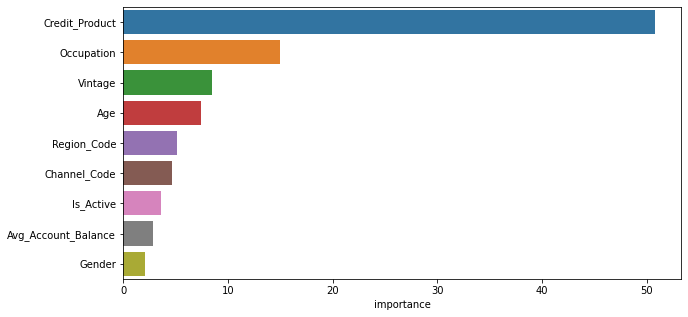

In [207]:
f_importance_df = pd.DataFrame(model.get_feature_importance(), columns=['importance'], index=X_test.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=f_importance_df.importance[:500], y=f_importance_df.index[:500])

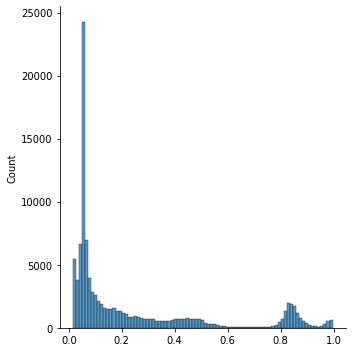

In [208]:
ypred_test = model.predict_proba(test.reindex(features, axis=1))[:,1]
sns.displot(ypred_test)


In [209]:
y_test['Is_Lead'].value_counts()

0    37520
1    11625
Name: Is_Lead, dtype: int64

In [194]:
# Submissions


test['Is_Lead'] = np.where(ypred_test <= threshold, 0, 1)

test.reset_index()[['ID', 'Is_Lead']].to_csv(f"{DATA_DIR}/catboost_submission.csv", index=False)


#### Cross Validation

In [219]:
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)
print(all_accuracies)
print(all_accuracies.mean())
print(all_accuracies.std())

0:	total: 76ms	remaining: 1m 15s
1:	total: 105ms	remaining: 52.6s
2:	total: 371ms	remaining: 2m 3s
3:	total: 427ms	remaining: 1m 46s
4:	total: 652ms	remaining: 2m 9s
5:	total: 811ms	remaining: 2m 14s
6:	total: 868ms	remaining: 2m 3s
7:	total: 1.09s	remaining: 2m 14s
8:	total: 1.15s	remaining: 2m 6s
9:	total: 1.21s	remaining: 2m
10:	total: 1.42s	remaining: 2m 7s
11:	total: 1.5s	remaining: 2m 3s
12:	total: 1.65s	remaining: 2m 5s
13:	total: 1.69s	remaining: 1m 59s
14:	total: 1.73s	remaining: 1m 53s
15:	total: 1.78s	remaining: 1m 49s
16:	total: 2.05s	remaining: 1m 58s
17:	total: 2.08s	remaining: 1m 53s
18:	total: 2.12s	remaining: 1m 49s
19:	total: 2.15s	remaining: 1m 45s
20:	total: 2.18s	remaining: 1m 41s
21:	total: 2.24s	remaining: 1m 39s
22:	total: 2.4s	remaining: 1m 41s
23:	total: 2.61s	remaining: 1m 46s
24:	total: 2.67s	remaining: 1m 44s
25:	total: 2.74s	remaining: 1m 42s
26:	total: 2.96s	remaining: 1m 46s
27:	total: 3.13s	remaining: 1m 48s
28:	total: 3.18s	remaining: 1m 46s
29:	total:

In [222]:
grid_param = {'depth': [6,10], 'n_estimators':[200, 500]}

gd_sr = GridSearchCV(estimator=model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gd_sr.fit(X_train, y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_
print(best_result)

0:	total: 132ms	remaining: 1m 5s
1:	total: 182ms	remaining: 45.4s
2:	total: 254ms	remaining: 42.1s
3:	total: 317ms	remaining: 39.3s
4:	total: 387ms	remaining: 38.3s
5:	total: 447ms	remaining: 36.8s
6:	total: 510ms	remaining: 35.9s
7:	total: 601ms	remaining: 36.9s
8:	total: 683ms	remaining: 37.3s
9:	total: 752ms	remaining: 36.8s
10:	total: 817ms	remaining: 36.3s
11:	total: 907ms	remaining: 36.9s
12:	total: 970ms	remaining: 36.3s
13:	total: 1.06s	remaining: 36.7s
14:	total: 1.12s	remaining: 36.2s
15:	total: 1.21s	remaining: 36.7s
16:	total: 1.3s	remaining: 37s
17:	total: 1.36s	remaining: 36.5s
18:	total: 1.41s	remaining: 35.8s
19:	total: 1.5s	remaining: 36.1s
20:	total: 1.56s	remaining: 35.5s
21:	total: 1.61s	remaining: 35.1s
22:	total: 1.75s	remaining: 36.2s
23:	total: 1.84s	remaining: 36.5s
24:	total: 1.95s	remaining: 37.1s
25:	total: 2.02s	remaining: 36.8s
26:	total: 2.09s	remaining: 36.5s
27:	total: 2.14s	remaining: 36.1s
28:	total: 2.21s	remaining: 36s
29:	total: 2.27s	remaining: 35

In [216]:
import catboost

cv_dataset = catboost.Pool(data=X,
                  label=y,
                  cat_features=categorical_features)

params = {"iterations": 1000,
          "depth": 10,
          "loss_function": "Logloss",
          "verbose": False}

scores = catboost.cv(cv_dataset,
            params,
            fold_count=5, 
            plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
scores

#### CatBoost Hyper Parameter Tuning & Optimization

In [ ]:

# params = {
#     'iterations': 10000,
#     'learning_rate': 0.01,
#     'depth': 6,
#     'cat_features': categorical_features,
#     'eval_metric': 'AUC',
#     'random_seed': 42,
#     # 'n_estimators': 10000,
# }

# # Initialize CatBoostClassifier
# model = CatBoostClassifier(**params, early_stopping_rounds=300)
# # Fit model
# model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=categorical_features, verbose=True) # , plot=True


#Instantiate CatBoostClassifier
cbc = CatBoostClassifier(cat_features=categorical_features, learning_rate=0.01, eval_metric='AUC')

#create the grid
grid = {'max_depth': [3,6,10], 'n_estimators':[200, 500]}

#Instantiate GridSearchCV
gscv = GridSearchCV (estimator = cbc, param_grid = grid, scoring ='accuracy', cv = 5)

#fit the model
gscv.fit(X.reindex(features, axis=1), y)


In [ ]:

#returns the estimator with the best performance
print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

#### XGBoost Model Training

In [20]:
# Defining Features & Target

target = ['Is_Lead']
features = imputed_transformed_train.columns.difference(target)

X = imputed_transformed_train[features]
y = imputed_transformed_train[target]


# Train Valid Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}")

X_train: (164635, 46)
X_test: (81090, 46)
y_train: (164635, 1)
y_test: (81090, 1)


In [39]:
import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)
dtest = xgb.DMatrix(X_test, label=y_test, missing=-999.0)

param = {'max_depth': 6, 'eta': 1, 'objective': 'binary:logistic'} # 'multi:softprob'
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 1000
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-auc:0.84549	train-auc:0.84945
[1]	eval-auc:0.84892	train-auc:0.85406
[2]	eval-auc:0.84932	train-auc:0.85568
[3]	eval-auc:0.84914	train-auc:0.85697
[4]	eval-auc:0.84908	train-auc:0.85832
[5]	eval-auc:0.84860	train-auc:0.85948
[6]	eval-auc:0.84863	train-auc:0.86050
[7]	eval-auc:0.84845	train-auc:0.86111
[8]	eval-auc:0.84821	train-auc:0.86161
[9]	eval-auc:0.84799	train-auc:0.86225
[10]	eval-auc:0.84769	train-auc:0.86270
[11]	eval-auc:0.84728	train-auc:0.86365
[12]	eval-auc:0.84723	train-auc:0.86408
[13]	eval-auc:0.84681	train-auc:0.86490
[14]	eval-auc:0.84662	train-auc:0.86523
[15]	eval-auc:0.84636	train-auc:0.86554
[16]	eval-auc:0.84616	train-auc:0.86623
[17]	eval-auc:0.84594	train-auc:0.86680
[18]	eval-auc:0.84552	train-auc:0.86738
[19]	eval-auc:0.84531	train-auc:0.86792
[20]	eval-auc:0.84506	train-auc:0.86855
[21]	eval-auc:0.84484	train-auc:0.86908
[22]	eval-auc:0.84481	train-auc:0.86952
[23]	eval-auc:0.84450	train-auc:0.87012
[24]	eval-auc:0.84433	train-auc:0.87051
[25]	eval-

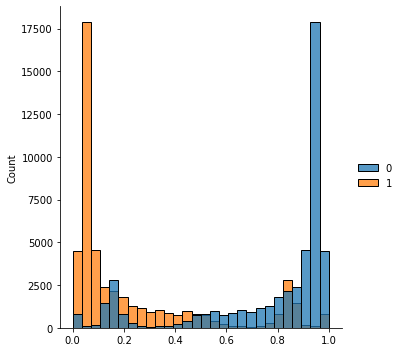

In [41]:
# Get predicted classes
preds_class = bst.predict(dtest)
sns.displot(preds_proba)


In [44]:
threshold = 0.5

preds_class = np.where(preds_class <= threshold, 0, 1)


In [46]:
print(f'roc_auc_score: {roc_auc_score(y_test, preds_class)}')
print(f'roc_auc_score: {roc_curve(y_test, preds_class)}')
precision, recall, thresholds = precision_recall_curve(y_test, preds_class)
print(f'precision: {precision}\nrecall: {recall}\nthresholds: {thresholds}')
print(f'confusion_matrix: {confusion_matrix(y_test, preds_class)}')

roc_auc_score: 0.6996628672024263
roc_auc_score: (array([0.        , 0.10855545, 1.        ]), array([0.        , 0.50788118, 1.        ]), array([2, 1, 0]))
precision: [0.23705759 0.592451   1.        ]
recall: [1.         0.50788118 0.        ]
thresholds: [0 1]
confusion_matrix: [[55151  6716]
 [ 9460  9763]]


<Figure size 1440x720 with 0 Axes>

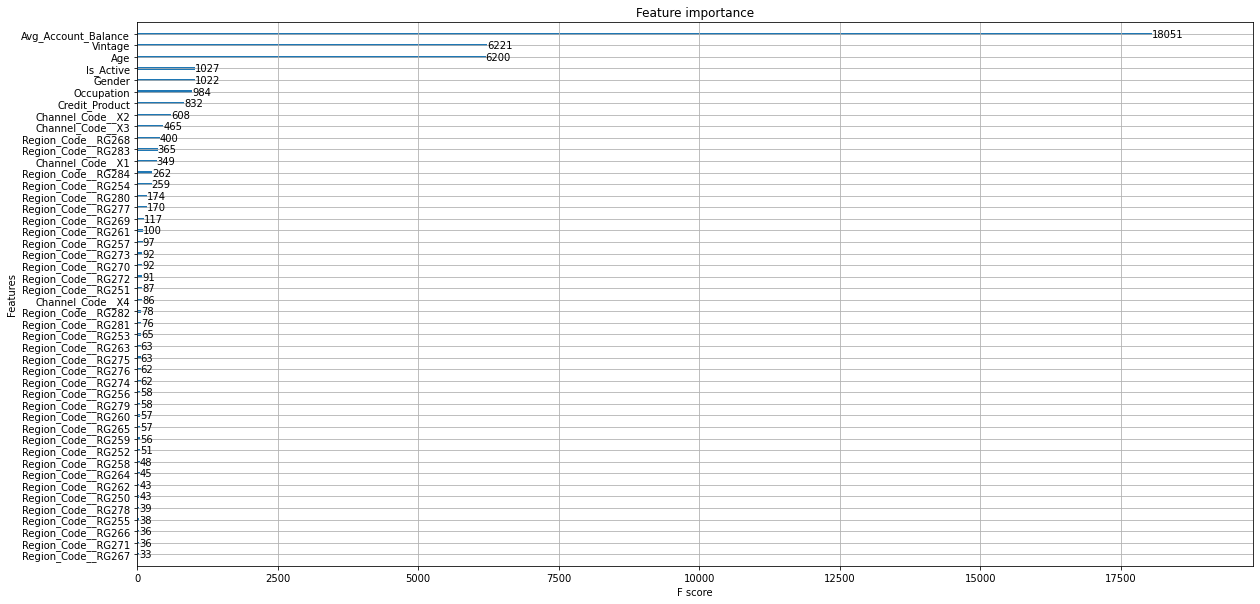

In [54]:
plt.figure(figsize=(20,10))
xgb.plot_importance(bst)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()


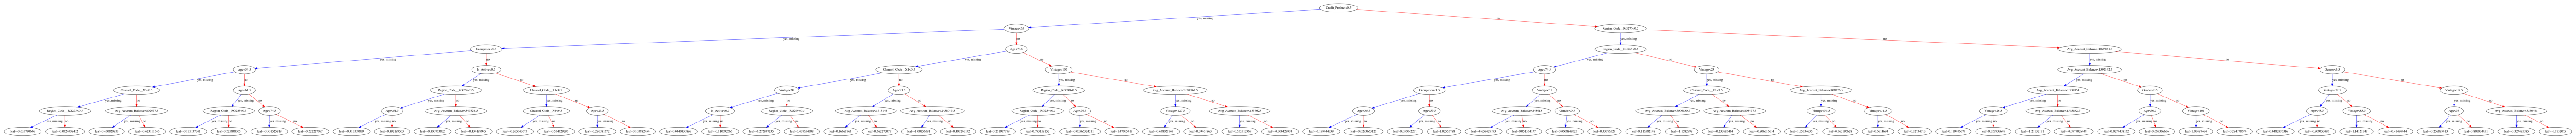

In [66]:
fig, ax = plt.subplots(figsize=(100, 50))
xgb.plot_tree(bst, num_trees=2, ax=ax)
plt.show()


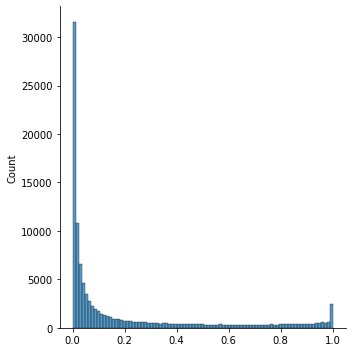

In [70]:
d_test = xgb.DMatrix(imputed_transformed_test.reindex(features, axis=1))

ypred_test = bst.predict(d_test)
sns.displot(ypred_test)


In [72]:
# Submissions

threshold = 0.5

test['Is_Lead'] = np.where(ypred_test <= threshold, 0, 1)

test.reset_index()[['ID', 'Is_Lead']].to_csv(f"{DATA_DIR}/xgboost_submission.csv", index=False)
